# Overview

**Resume:**

PanGaia facilitates the access, exploration, and clustering analysis of the Gaia DR2 [catalogue](https://gea.esac.esa.int/archive/).
Its main target audience is the community of astromers working in the topic of star formation who are *familiar* with the Gaia archive.


**Main steps:**
1. The code asks the user to provide the coordinates and constraints to perform an [ADQL](http://www.ivoa.net/documents/ADQL/2.0) cone-search (e.g. [link](https://gea.esac.esa.int/archive-help/adql/examples/index.html)) in the Gaia archive. If a control sample is provided PanGaia will compute its average R.A. ($\alpha$) and declination ($\delta$) to center the cone search. Once the coordinates and constraints are set the code will execute the ADQL query using the [astroquery.gaia](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html) package, and download a .vot table with the data to the current directory. PanGaia will add several columns to the table like e.g. the distance (computed as the inverse of the parallax, $d = 1/\varpi$).



2. The downloaded dataset can be visualised with [pyESASky](https://www.cosmos.esa.int/web/esdc/pyesasky), and interactively inspected with the [plotly](https://plot.ly/python/) Python library.


3. Clusters (overdensities) in the 5-dimensional space defined by the 3 Cartesian dimensions (X,Y, and Z in Galactic coordinates), and the 2 proper motions $\mu_{\alpha}^*$ and $\mu_{\delta}$) of the downloaded dataset are identified using a clustering algorithm. The current version of the notebook uses the HDBSCAN algorithm (an unsupervised Machine Learning, density-based, clustering algorithm) as implemented in [here](https://hdbscan.readthedocs.io/en/latest/).


**Products:**

The main products of PanGaia are 1) the data sample downloaded from the Gaia archive, and 2) the clusters identified by the HDSBCAN algorithm.
Additionally the code creates a set of PDF files illustrating the intermediate steps of the analysis.


**Notes:**

TbD


This notebook was written by Héctor Cánovas (hcanovas@sciops.esa.int), and is licensed under a MIT License

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1">Overview</a></span></li><li><span><a href="#Customize-Pangaia:" data-toc-modified-id="Customize-Pangaia:-2">Customize Pangaia:</a></span></li><li><span><a href="#1.--Load-Control-Sample" data-toc-modified-id="1.--Load-Control-Sample-3">1.- Load Control Sample</a></span></li><li><span><a href="#2.--Run-pyESASky" data-toc-modified-id="2.--Run-pyESASky-4">2.- Run pyESASky</a></span></li><li><span><a href="#3.--Construct-Data-Sample" data-toc-modified-id="3.--Construct-Data-Sample-5">3.- Construct Data Sample</a></span></li><li><span><a href="#Visual-Inspection" data-toc-modified-id="Visual-Inspection-6">Visual Inspection</a></span></li><li><span><a href="#Clustering-Analysis" data-toc-modified-id="Clustering-Analysis-7">Clustering Analysis</a></span></li><li><span><a href="#Compare-to-Control" data-toc-modified-id="Compare-to-Control-8">Compare to Control</a></span></li><li><span><a href="#Save-HDBSCAN-Output" data-toc-modified-id="Save-HDBSCAN-Output-9">Save HDBSCAN Output</a></span></li></ul></div>

In [11]:
# Python Basics ========================
import warnings, sys
warnings.filterwarnings('ignore', category=UserWarning)
sys.path.append('../library/')

# Custom ===============================
from lib_utils       import LibUtils       as Utils
from lib_gaia_query  import LibGaiaQuery   as GaiaQuery
from lib_interactive import LibInteractive as Interactive
from lib_cluster     import LibCluster     as Cluster
from lib_plotters    import LibPlotters    as Plotters
from lib_compare     import LibCompare     as Compare

# pyESASky =============================
from pyesasky.pyesasky import ESASkyWidget

# Adjust cell size =====================
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) ## Adjust cell size as you wish

# Customize Pangaia:

The notebook is divided into 4 separated steps or blocks, each of which is indepent from the others. To decide how to run PanGaia set the steps to ```True/False``` below.

In [12]:
step_1 = True # Load Control Sample
step_2 = True # ESASky Plot
step_3 = True # Interactive/Dynamical Gaia Data exploration (Plotly)
step_4 = True # Clustering Analysis (HDSBCAN)

# 1.- Load Control Sample

The control sample is loaded if ```step_1 = True``` below. There are a number of variables that can be easily set by the user:
* Line  3: Set the control sample color and label.
* Line  4: Set the directory from where the control samples are read. The code searches for the .vot tables stored in this directory and asks the user to choose one of them. Alternatively, the control sample can be specified as e.g., ```control.read_catalogue('../samples_control/sample_control_IC_348.vot')```
* Line  5: Set the number of control sample rows to be displayed (starting from the first row).
* Line 10: Set the dimensions to be displayed in the plot and in the histogram by changing the ```col_hist, col_x, and col_y``` arguments.


Sample Catalogues in ../samples_control/: ==============================================

* sample_control_IC_348.vot
* sample_control_OPH.vot
* sample_control_NGC_1333.vot

Choose Control Sample: sample_control_IC_348.vot
Sample Control loaded. N_elements (rows) = 144

Checking catalogue columns (ra, dec, parallax, pmra, phot_g_mean_mag, etc) - OK

Showing Sample Control first 5 rows:


col2mass,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,l,b,visibility_periods_used,radial_velocity,unit_weight_e,ruwe,distance,phot_g_mean_mag_abs,phot_bp_mean_mag_abs,phot_rp_mean_mag_abs,phot_g_mean_mag_err,phot_bp_mean_mag_err,phot_rp_mean_mag_err,X_gal,Y_gal,Z_gal,pm_mod
,,deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mag,mag,mag,,,,deg,deg,,km / s,,,pc,mag,mag,mag,mag,mag,mag,pc,pc,pc,
bytes16,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,int16,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64
03430679+3148204,216575791780899200,55.77832585931487,31.805676998022935,3.368292212211576,0.18569575746121944,4.153055103839073,0.24327365471569765,-7.238032874307061,0.1874717775215194,16.336063,18.711496,14.907626,627.83307,41.59013,198.40709,160.48133628908516,-18.274279107720577,9,--,1.8418794652984396,1.078421,296.8863557545719,8.973112190843308,11.348545158982956,7.544674957872116,0.0015927801,0.024044167,0.0050401427,-265.71249557733364,94.19114879201432,-93.09353047627064,8.344877865198118
03432622+3159286,216673162984386944,55.859323289998294,31.99127822034385,2.632751869978748,0.2504633438776319,4.608158705333078,0.4623583068436142,-6.940869193945712,0.2801396522260879,18.188923,20.33305,16.75615,508.76843,14.258361,157.91954,160.41233815127958,-18.08751919003965,9,--,1.1610862156055872,0.96449953,379.8307054314511,10.290972531622979,12.435099423712822,8.858198941535088,0.0019655307,0.07013429,0.006332339,-340.1660512901451,121.04514881599239,-117.92579991816214,8.331313931247678
03432774+3208314,216692099496268288,55.86564895264847,32.142068755211675,3.315366603457813,0.20983146461589036,4.584408968543563,0.43174948098974925,-7.2091046805227315,0.24425233421779075,17.565023,19.63398,16.151264,601.43933,24.294651,176.66731,160.31545184985518,-17.968026007948183,8,--,1.1918276439315283,0.94958436,301.6257686124468,10.167681214234388,12.236637589356459,8.753921982667006,0.0016626781,0.041161325,0.0056603565,-270.1482103718381,96.64487582456944,-93.04738954315665,8.543301228775526
03433205+3206172,216685949103101824,55.88362722579706,32.104790681581335,2.9996222049239414,0.05954141609718637,3.555695459980017,0.1183264543616157,-6.921575941462564,0.06722023993853171,14.828465,15.982068,13.762056,661.0584,126.30815,243.22202,160.35279023811825,-17.987003245808655,8,--,1.2506929608546613,1.0847275,333.375315850936,7.213798260914656,8.367400861012312,6.147389149891707,0.0015127256,0.007917145,0.0041114697,-298.6218375242565,106.61178748238133,-102.94671506249932,7.78146411143532
03433365+3201451,216673678380015232,55.89025861343185,32.029207864923364,3.2290728529141717,0.1792326043703605,4.7918714236640385,0.325847169733034,-7.534572612363947,0.20241032929788338,17.243881,--,--,416.147,--,--,160.40809188995905,-18.0415794082769,9,--,1.399380613109474,1.3609223,309.68641636484625,9.78927044302494,--,--,0.002402997,--,--,-277.4119577216782,98.73781033456953,-95.91207955341868,8.929267393908242


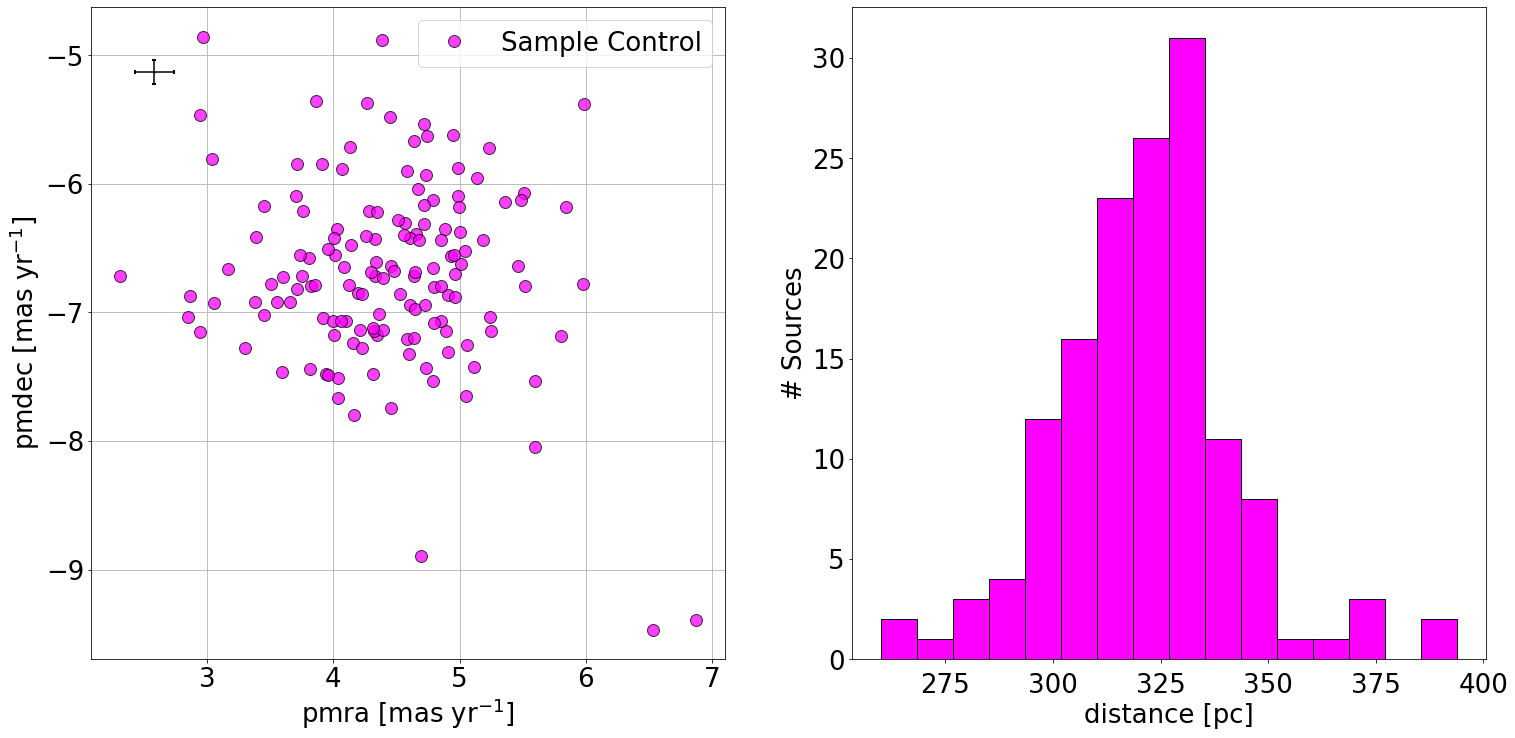

In [13]:
# Load Control Sample ==================================
if step_1:
    control = Utils(color = 'magenta', label = 'Sample Control')
    control.read_catalogue(sample_dir = '../samples_control/')
    control.display_N_rows(N_rows = 5, verbose = True)

    # Examine Velocity & Histograms ====================
    figures  = Plotters()
    figures.load_gaia_cat(control.cat)
    figures.plot_2d_and_hist(col_x = 'pmra', col_y = 'pmdec', col_hist = 'distance', label = control.label, 
                             color_2d = control.color, color_hist = control.color)    

# 2.- Run pyESASky
pyESASKy is a python widget that opens an [ESASky](https://sky.esa.int/?target=273.2303166666667%2068.36347222222221&hips=DSS2%20color&fov=0.09993670884473815&cooframe=J2000&sci=true&lang=en) window locally. This widget will open if ```step_2 = True``` in Cell #2, allowing to visualise the control and/or queried sample. By default, the control sample is represented as magenta squares (following the color set in Cell #5, line 3) on top of a RGB background mid-infrared image. Different backgrounds can be set by clicking in the "manage skies" buttom of the widget (top left). If there is no control sample the widget will open displaying a randomn astronomy image.

In [14]:
# Run ESASKY ===========================================
if step_2:
    esasky = ESASkyWidget()
    display(esasky)
    
    if step_1:
        figures_0  = Plotters()
        figures_0.load_gaia_cat(control.cat)
        figures_0.send_to_ESASky(esasky, color=control.color, catalogueName = control.label)    

ESASkyWidget(layout=Layout(align_self='stretch', height='400px'))

hipsURL http://cdn.skies.esac.esa.int/AllWISEColor/
imgFormat jpeg


# 3.- Construct Data Sample

The cell below executes an [ADQL](http://www.ivoa.net/documents/ADQL/2.0) cone-search query in the Gaia archive. If the Control sample has been loaded before, its average $\alpha$ and $\delta$, its maximum and minimum $\varpi$, and its projected radius on-sky will be displayed to help to define the query. The code will ask for a name that will be used to save the output of the query and it will serve as the rootname for all the data products created by this notebook. Afterwards PanGaia will define the central coordinates of the query. If the control sample has been loaded then its average coordinates [$\alpha, \delta$] will be used to center the cone search. Otherwise, the code will ask the user to input them. In any of the cases the code will additionally ask for the cone-search radius and for a minimum/maximum parallax range to constrain the query. To download a sample that encompases the entire control sample the query radius shoud be larger than that of the control sample, and the parallax range should be set accordingly. Additionally, PanGaia includes three quality constraints (line 11 in the Cell below): 

```sample_queried.run_cone_search(quality_par_SN  = '10', quality_par_vis = '7',quality_par_ruwe = '1.40')```

The first argument set the minimum signal to noise (S/N) of the parallax. To convert from parallax to distance using $d = 1./\varpi$ this parameter must be $\ge 10$ [(Bailer-Jones (2015))](https://ui.adsabs.harvard.edu/abs/2015PASP..127..994B/abstract). The second argument indicates the minimum amount of [visibility periods](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html)
used to compute the astrometric solution for each source. The third argument indicates the maximun value of the [RUWE](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_ruwe.html)
parameter.

Once the coordinates and constraints are set the code executes the ADQL query using the [astroquery.gaia](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html) package, downloading a .vot table with the query output to the current directory. Information regarding the query, its status, and the general properties of the downloaded sample will be displayed. As it happens when loading the control sample, the user can associated a color and a label to this dataset. By defaul, the label is the name set at the beggining of the query, and the color is set to grey.

In [16]:
# Set Cone-search query parameters and constraints =====
sample_queried = GaiaQuery()
if step_1:
    control.print_cone_properties()
    sample_queried.set_cone_search_pars(ra = control.ADQL_pars['ra'].value, 
                                        dec = control.ADQL_pars['dec'].value)
else:
    sample_queried.set_cone_search_pars()

# Execute cone-search query and download data ==========
sample_queried.run_cone_search(quality_par_SN  = '10.2', quality_par_vis = '7.1', quality_par_ruwe = '1.40')


# Load data sample for analysis ======================== 
sample_gaia = Utils(color = 'grey', label = sample_queried.sample_name)
sample_gaia.read_catalogue(sample_queried.cat, save_sample = True, print_vrad = True)
sample_gaia.display_N_rows(N_rows = 5, verbose = True)

Sample Control on-Sky sample properties:
* Average R.A.         56.12, deg
* Average Dec.         32.16, deg
* Radius on-sky         0.30, deg
* Parallax min          2.51, mas
* Parallax max          3.92, mas
Introduce sample name (e.g. IC_348_test): TEST
Preparing Cone-Search ADQL query. Introduce radius [decimal degree]: 1.
Preparing Cone-Search ADQL query. Introduce min-Parallax [mas]: 2.4
Preparing Cone-Search ADQL query. Introduce max-Parallax [mas]: 4.1

RUNNING ADQL ASYNCRHRONOUS QUERY =========================================================
Launched query: 'SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, gaia.phot_g_mean_flux_over_error, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.l, gaia.b, gaia.visibility_periods_used, gaia.radial_velocity ,sqrt(gaia.astrometric_chi2_al/(gaia.astrometric_n

source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,l,b,visibility_periods_used,radial_velocity,unit_weight_e,ruwe,distance,phot_g_mean_mag_abs,phot_bp_mean_mag_abs,phot_rp_mean_mag_abs,phot_g_mean_mag_err,phot_bp_mean_mag_err,phot_rp_mean_mag_err,X_gal,Y_gal,Z_gal,pm_mod
,deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mag,mag,mag,,,,deg,deg,,km / s,,,pc,mag,mag,mag,mag,mag,mag,pc,pc,pc,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,int16,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64
216403099737497216,56.390825603576445,31.333914206170537,2.696193297927105,0.07917044231652512,3.175267797475226,0.12482863925138177,-5.07733380712027,0.08143771024102295,15.44325,16.783953,14.296078,801.7088,123.525955,216.32027,161.22170352089702,-18.301000286377647,10,--,1.3870029652621045,1.102411,370.9,7.597004826513695,8.937707837072777,6.449832852331566,0.0012473357,0.008095465,0.0046227756,-333.3898840956781,113.35426949915181,-116.46384237621503,5.988459248805955
216558298378625920,55.25861650210676,31.647406880598645,3.224076805430021,0.2654580123877,-0.821968213476409,0.3834020346543497,-16.79078933117509,0.2773816811405739,17.864826,19.706486,16.498363,526.03845,15.833649,223.8,160.2277261302588,-18.677512049550884,9,--,1.3102413966004456,1.1112864,310.2,10.40685309848142,12.248512644379858,9.040390390961889,0.0019010017,0.063156635,0.0044682752,-276.5087495344675,99.39815231095002,-99.32802964161567,16.810896410003508
216389763861636352,56.446464839546096,31.219103331613546,3.9562233159816,0.19568389463755947,30.84567951473386,0.3304100273438955,-23.64134242274264,0.21218613434354722,17.934797,19.605299,16.637209,786.02844,27.178444,170.55228,161.3380805007045,-18.35790973458561,10,--,1.1711001243506194,1.0216268,252.8,10.921201277650978,12.591702986635353,9.623612929262306,0.0012722187,0.036793865,0.0058633047,-227.28912937252412,76.76479323256497,-79.60923066067359,38.86346634404917
216433301947549952,57.06975817287067,31.75431113129947,2.637779247604118,0.1513710311322407,18.27541004400568,0.27625222169517266,-3.742804990590623,0.1663226218357889,16.958202,18.330004,15.783369,1223.1678,61.9091,311.22287,161.39824901023272,-17.605791980118738,10,--,1.1938366998442582,1.059503,379.1,9.064394597947437,10.43619597429021,7.889561300217945,0.0008175493,0.016152713,0.0032131316,-342.4720770928839,115.26623913915687,-114.6670050911107,18.654736703425588
216537480672641792,55.466510229352586,31.430880917718444,2.706459646043687,0.1503798189871731,14.385083412972623,0.2549898064677312,-11.136573847500825,0.17661636087485527,16.955603,18.615915,15.688988,1021.88995,49.055546,277.64572,160.51738413107853,-18.73232816611092,9,--,1.2983398785770266,1.0781915,369.5,9.117610426081281,10.777923078669172,7.850995512140852,0.0009785789,0.020385055,0.0036017122,-329.87926422553994,116.70374634923137,-118.65958808267457,18.19213846305649


The downloaded sample will be displayed in pyESASky (Cell #6) if ```step_2 = True``` in Cell #2. By default the sample is represented as white squares.

In [9]:
# Show output in ESASky ================================
if step_2:
    figures  = Plotters()
    figures.load_gaia_cat(sample_gaia.cat)
    figures.send_to_ESASky(esasky, color= 'white', 
                           radius = sample_gaia.ADQL_pars['radius'].value, catalogueName = sample_gaia.label)

hipsURL http://cdn.skies.esac.esa.int/AllWISEColor/
imgFormat jpeg


# Visual Inspection


The cell below allows to interactively inspect the downloaded dataset using the [plotly](https://plot.ly/python/) Python library. PanGaia will open 3 dynamical pannels, with the downloaded sample represented as grey semi-transparent circles, and they control sample as magenta (by default) circles.

In [10]:
# Examine astrometry ===================================
if step_3:
    i_figures = Interactive()
    i_figures.load_gaia_cat(sample_gaia.cat)
    if step_1:
            i_figures.load_control_obj(control)
    i_figures.explore_and_select(opacity = 0.5, border_width = 1, color_def = 'black', color_high = 'cyan')
    display(i_figures.dashboard)

Exporting Astropy Table to Pandas
Exporting Control Table to Pandas


    'data': [{'marker': {'cmax': 1.5,
                         'c…

In [ ]:
# Show 3D distribution =================================
if step_2 and step_3:
    if hasattr(i_figures, 'cat_subsamp'):
        print('Plotting Subsample in ESASky')
        figures.add_catalogue_to_ESASky(esasky, i_figures.cat_subsamp, color='cyan', catalogueName='SubSamp', radius = sample_gaia.ADQL_pars['radius'].value)

if step_3:
    i_figures.show_3D_space(width = 1200, height=700, size = 5, color_def = 'black')
    display(i_figures.fig_3D)

# Clustering Analysis

In [ ]:
# Scale before clustering ==============================
if step_4:
    data_clustering = Cluster()
    data_clustering.read_data_obj(sample_gaia, scl_features = ['X_gal', 'Y_gal', 'Z_gal', 'pmdec', 'pmra'])

In [ ]:
# Run HDBSCAN through a range of min samples ===========
if step_4:
    data_clustering.run_multi_hdbscan(verbose = True, show_plot = False)
    data_clustering.plot_multi_hdbscan_stats(fig_nm = 'default')

In [ ]:
# Show selected HDBSCAN results ========================
if step_4:
    data_clustering.run_hdbscan(probability = data_clustering.probability, min_samples=data_clustering.min_samples, verbose = True)
    data_clustering.plot_hdbscan_clusters()


if step_2:
        data_clustering.esasky_hdbscan_clusters(esasky, radius = sample_gaia.ADQL_pars['radius'].value)

# Compare to Control

In [ ]:
# Cluster Comparison ===================================
if step_1:
    comp = Compare()
    comp.read_control(control, mew = 2)
    comp.read_clusters(data_clustering, verbose = False)
    comp.compare_to_control(verbose = True)
    print()
    comp.plot_clusters_comp(markersize = 16, fig_nm = 'default', fontsize = 20)    

# Save HDBSCAN Output

In [ ]:
if step_4:
    data_clustering.save_cluster()

This notebook was written by Héctor Cánovas (hcanovas@sciops.esa.int), and is licensed under a MIT License